In [291]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, Activation, Dropout
from tensorflow.keras import optimizers
# from keras_preprocessing.image import ImageDataGenerator

import time 
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
import numpy as np

from matplotlib import image
from sklearn.preprocessing import LabelEncoder

In [205]:
label_tr = pd.read_csv("fairface_label_train.csv")
label_te = pd.read_csv("fairface_label_val.csv")
label_tr.head(3)

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False


In [241]:
def load_img_dataset_with_label(df,label):
    x = []
    y = df[label].astype('category').cat.codes
    for i in range(len(df)):
        x.append(image.imread(df['file'][i]))
    return np.array(x, dtype='float32'), np.array(y)
    
x_train_r, y_train_r = load_img_dataset_with_label(label_tr, "race")
x_train_g, y_train_g = load_img_dataset_with_label(label_tr, "gender")

x_test_r, y_test_r = load_img_dataset_with_label(label_te, "race")
x_test_g, y_test_g = load_img_dataset_with_label(label_te, "gender")

In [272]:
# Normalize using MinMax Scalar

def MinMaxScaling(a):
    return (a - a.min()) / (a.max() - a.min())

xr_tr, xg_tr = MinMaxScaling(x_train_r), MinMaxScaling(x_train_g)
xr_te, xg_te = MinMaxScaling(x_test_r), MinMaxScaling(x_test_g)

xr_tr.shape

(86744, 32, 32)

In [297]:
encoder = LabelEncoder()
encoder.fit(y_train_r)
yr_tr, yg_tr = encoder.transform(y_train_r), encoder.transform(y_train_g)
yr_te, yg_te = encoder.transform(y_test_r), encoder.transform(y_test_g)


In [326]:
model_1g = Sequential(name="task1_g")
model_1g.add(Flatten())
model_1g.add(layers.Dense(1024, activation='tanh'))
model_1g.add(layers.Dense(512, activation='sigmoid'))
model_1g.add(layers.Dense(100, activation='relu'))
model_1g.add(layers.Dense(2, activation='softmax'))

model_1g.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
                 metrics=['accuracy'])

history_1g = model_1g.fit(x=xg_tr, y=yg_tr, 
                          epochs=10,
                          validation_data = (xg_te,yg_te),
                          verbose=1)

print(model_1g.summary())

Epoch 1/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.6505 - accuracy: 0.6172 - val_loss: 0.6293 - val_accuracy: 0.6438
Epoch 2/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.6150 - accuracy: 0.6613 - val_loss: 0.5926 - val_accuracy: 0.6839
Epoch 3/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.5948 - accuracy: 0.6783 - val_loss: 0.5854 - val_accuracy: 0.6859
Epoch 4/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.5810 - accuracy: 0.6881 - val_loss: 0.5665 - val_accuracy: 0.6988
Epoch 5/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.5707 - accuracy: 0.6916 - val_loss: 0.5634 - val_accuracy: 0.6969
Epoch 6/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.5625 - accuracy: 0.6985 - val_loss: 0.5723 - val_accuracy: 0.6934
Epoch 7/10
2711/2711 [==============================] - 21s 8ms/step - loss: 0.5568 - accuracy: 0.7017 - val_loss: 0.5533 - val_ac

Predicted  Female  Male
Actual                 
Female       1294  3865
Male         1473  4312


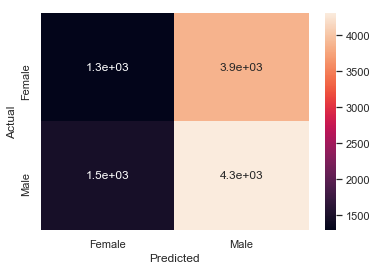

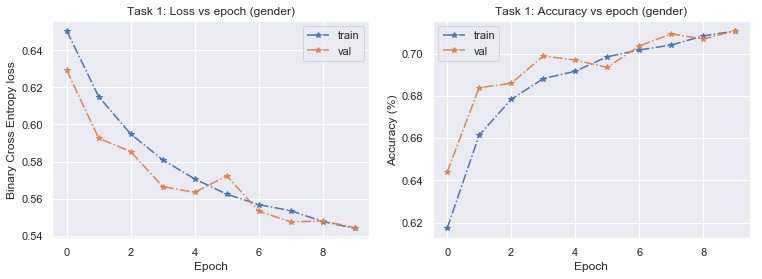

In [346]:
pred_1g = model_1g.predict(xg_te)
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices.shape
labels = {0: "Female", 1: "Male"}
predictions = [labels[k] for k in predicted_class_indices]

data = {'y_Actual':    testdf['gender'][:-10],
        'y_Predicted': predictions
        }

df_cm = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)

plt.figure(figsize=[12.5,4])
plt.subplot(1,2,1)
plt.plot(history_1g.history['loss'],'-.*', label='train')
plt.plot(history_1g.history['val_loss'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy loss")
plt.title("Task 1: Loss vs epoch (gender)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_1g.history['accuracy'],'-.*', label='train')
plt.plot(history_1g.history['val_accuracy'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Task 1: Accuracy vs epoch (gender)")
plt.legend()

In [344]:
model_1r = Sequential(name="task1_r")
model_1r.add(Flatten())
model_1r.add(layers.Dense(1024, activation='tanh'))
model_1r.add(layers.Dense(512, activation='sigmoid'))
model_1r.add(layers.Dense(100, activation='relu'))
model_1r.add(layers.Dense(7, activation='softmax'))

model_1r.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
                 metrics=['accuracy'])

history_1r = model_1r.fit(x=xr_tr, y=yr_tr, 
                          epochs=10, 
                          validation_data = (xr_te,yr_te),
                          verbose=1)

print(model_1r.summary())

Epoch 1/10
2711/2711 [==============================] - 20s 7ms/step - loss: 1.8364 - accuracy: 0.2613 - val_loss: 1.7800 - val_accuracy: 0.2946
Epoch 2/10
2711/2711 [==============================] - 22s 8ms/step - loss: 1.7278 - accuracy: 0.3224 - val_loss: 1.6898 - val_accuracy: 0.3345
Epoch 3/10
2711/2711 [==============================] - 21s 8ms/step - loss: 1.6768 - accuracy: 0.3468 - val_loss: 1.6972 - val_accuracy: 0.3308
Epoch 4/10
2711/2711 [==============================] - 20s 8ms/step - loss: 1.6478 - accuracy: 0.3584 - val_loss: 1.6286 - val_accuracy: 0.3628
Epoch 5/10
2711/2711 [==============================] - 20s 8ms/step - loss: 1.6251 - accuracy: 0.3679 - val_loss: 1.6036 - val_accuracy: 0.3826
Epoch 6/10
2711/2711 [==============================] - 20s 7ms/step - loss: 1.6074 - accuracy: 0.3754 - val_loss: 1.6092 - val_accuracy: 0.3749
Epoch 7/10
2711/2711 [==============================] - 20s 8ms/step - loss: 1.5890 - accuracy: 0.3819 - val_loss: 1.6149 - val_ac

Predicted        East Asian  White
Actual                            
Black                   399   1156
East Asian              384   1165
Indian                  387   1129
Latino_Hispanic         429   1192
Middle Eastern          297    912
Southeast Asian         360   1053
White                   511   1570


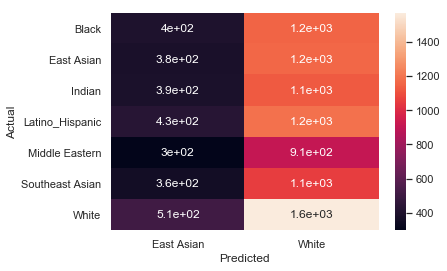

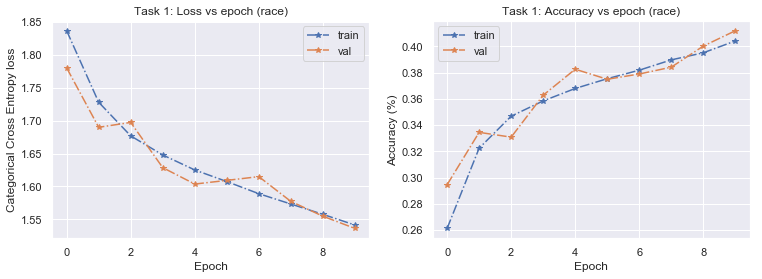

In [345]:
pred_1r = model_1r.predict(xr_te)
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices.shape
labels = testdf['race'].unique()
predictions = [labels[k] for k in predicted_class_indices]

data = {'y_Actual':    testdf['race'][:-10],
        'y_Predicted': predictions
        }

df_cm = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)

plt.figure(figsize=[12.5,4])
plt.subplot(1,2,1)
plt.plot(history_1r.history['loss'],'-.*', label='train')
plt.plot(history_1r.history['val_loss'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross Entropy loss")
plt.title("Task 1: Loss vs epoch (race)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_1r.history['accuracy'],'-.*', label='train')
plt.plot(history_1r.history['val_accuracy'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Task 1: Accuracy vs epoch (race)")
plt.legend()

In [33]:
# Task 2: Small CovNet

model_2g = Sequential(name="Task 2: Gender")
model_2g.add(layers.Conv2D(filters=40,kernel_size=5,strides=1,
                        padding='valid',activation='relu',
                        input_shape=(32,32,3), name="conv2d_2g"))
model_2g.add(layers.MaxPooling2D(pool_size=2, name="maxpooling2d_2g"))
model_2g.add(layers.Flatten(name="flatten_2g"))
model_2g.add(layers.Dense(100,activation='relu', name="dense_2g"))
model_2g.add(layers.Dense(2,activation='softmax', name="output_2g"))

# print(model_2g.summary())

# model_2g.compile(loss='binary_crossentropy', 
#                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
#                  metrics=['accuracy'])

# model_2r = Sequential(name="Task 2: Race")
# model_2r.add(layers.Conv2D(filters=40,kernel_size=5,strides=1,
#                         padding='valid',activation='relu',
#                         input_shape=(32,32,1), name="conv2d_2r"))
# model_2r.add(layers.MaxPooling2D(pool_size=2, name="maxpooling2d_2r"))
# model_2r.add(layers.Flatten(name="flatten_2r"))
# model_2r.add(layers.Dense(100,activation='relu', name="dense_2r"))
# model_2r.add(layers.Dense(7,activation='softmax', name="output_2r"))
# print(model_2r.summary())

# model_2r.compile(loss="categorical_crossentropy", 
#                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
#                  metrics=['accuracy'])

Model: "Task 2: Gender"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2g (Conv2D)           (None, 28, 28, 40)        1040      
_________________________________________________________________
maxpooling2d_2g (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
flatten_2g (Flatten)         (None, 7840)              0         
_________________________________________________________________
dense_2g (Dense)             (None, 100)               784100    
_________________________________________________________________
output_2g (Dense)            (None, 2)                 202       
Total params: 785,342
Trainable params: 785,342
Non-trainable params: 0
_________________________________________________________________
None
Model: "Task 2: Race"
_________________________________________________________________
Layer (type)       

In [41]:
# Task 3: Your own Convolutional Neural Network 

model_3g = Sequential(name="Task 3: Gender")
model_3g.add(layers.Conv2D(filters=64,kernel_size=7,strides=1,
                        padding='same',activation='relu',
                        input_shape=(32,32,1)))
model_3g.add(layers.MaxPooling2D(pool_size=2))
model_3g.add(layers.Lambda(tf.nn.local_response_normalization))
model_3g.add(layers.Conv2D(filters=64,kernel_size=1,strides=1,
                          padding='same', activation='relu'))
model_3g.add(layers.Conv2D(filters=192, kernel_size=3,strides=1,
                          padding='same',activation='relu'))
model_3g.add(layers.MaxPooling2D(pool_size=2))
model_3g.add(layers.Flatten())
model_3g.add(layers.Dense(2))

print(model_3g.summary())

Model: "Task 3: Gender"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        3200      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        4160      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 192)       110784    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 192)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)          

In [53]:
# Task 4: Your own ConvNet on both tasks simultaneously 

input = layers.Input(shape=(32,32,1))
conv1 = layers.Conv2D(filters=64,kernel_size=7,strides=1,
                    padding='same',activation='relu',
                    name='conv1')(input)
max1 = layers.MaxPool2D(pool_size=(3,3),strides=(2,2),
                        padding="same",name='pool1')(conv1)
lrn1 = tf.keras.layers.Lambda(
                    tf.nn.local_response_normalization)(max1)
conv2 = layers.Conv2D(filters=64,kernel_size=(1,1),
            padding="same",strides=1,activation="relu",name='conv2')(lrn1)
conv3 = layers.Conv2D(filters=192,kernel_size=(3,3),
            padding="same",strides=1,activation="relu",name='conv3')(conv2)
lrn2 = tf.keras.layers.Lambda(
                    tf.nn.local_response_normalization)(conv3)
max2 = layers.MaxPool2D(pool_size=(3,3),strides=(2,2),
            padding="same",name='pool2')(conv3)
fltn1 = layers.Flatten()(max2)
fc1 = layers.Dense(2)(fltn1)
fltn2 = layers.Flatten()(max2)
fc2 = layers.Dense(7)(fltn1)
output = layers.concatenate([fc1, fc2], axis=1)

model_4g = keras.Model(inputs=input,outputs=output, name="Your own convnet")

# model_4g.compile(loss="categorical_crossentropy")

print(model_4g.summary())




Model: "Your own convnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        input_17[0][0]                   
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 16, 16, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
lambda_35 (Lambda)              (None, 16, 16, 64)   0           pool1[0][0]                      
___________________________________________________________________________________

In [58]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
from tensorflow.keras import backend as K

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

In [67]:
# Task 5: Variational Auto Encode

latent_dim = 5

inputs = Input(shape=(32,32,1), name='encoder_input')
encoder_hl1 = layers.Conv2D(64, kernel_size=7, strides=1, 
                    activation='relu', name='encoder_hl1',
                    padding='same')(inputs)
encoder_hl2 = layers.Conv2D(128, kernel_size=3, strides=1, 
                    activation='relu', name='encoder_hl2',
                    padding='same')(encoder_hl1)
encoder_flatten = layers.Flatten()(encoder_hl2)
z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_flatten)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_flatten)

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs,[z_mean,z_log_var,z], name='encoder_output')
encoder.summary()

Model: "encoder_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
encoder_hl1 (Conv2D)            (None, 32, 32, 64)   3200        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_hl2 (Conv2D)            (None, 32, 32, 128)  73856       encoder_hl1[0][0]                
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 131072)       0           encoder_hl2[0][0]                
_____________________________________________________________________________________

In [68]:
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
decoder_dense = layers.Dense(32*32*128, activation='relu')(latent_inputs)
decoder_reshape = layers.Reshape((32,32,128))(decoder_dense)
decoder_hl1 = layers.Conv2DTranspose(128, kernel_size=3, strides=1,
                activation='relu', name='decoder_hl1',
                padding='same')(decoder_reshape)
decoder_hl2 = layers.Conv2DTranspose(64, kernel_size=7,strides=1,
                activation='relu', name='decoder_hl2',
                padding='same')(decoder_hl1)
decoder_outputs = layers.Conv2DTranspose(1,3, activation="sigmoid",
                padding='same')(decoder_hl2)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 5)]               0         
_________________________________________________________________
dense_38 (Dense)             (None, 131072)            786432    
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
decoder_hl1 (Conv2DTranspose (None, 32, 32, 128)       147584    
_________________________________________________________________
decoder_hl2 (Conv2DTranspose (None, 32, 32, 64)        401472    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 1)         577       
Total params: 1,336,065
Trainable params: 1,336,065
Non-trainable params: 0
_________________________________________________

In [73]:
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

#setting loss
reconstruction_loss = keras.losses.mse(inputs, outputs)
reconstruction_loss *=1
kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.001
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Task 3: 
Race

In [185]:
# Task 3: Your Own ConvNet (Race)
model_3r = Sequential()
model_3r.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model_3r.add(Activation('relu'))
model_3r.add(Conv2D(32, (3, 3)))
model_3r.add(Activation('relu'))
model_3r.add(MaxPooling2D(pool_size=(2, 2)))
model_3r.add(Dropout(0.25))
model_3r.add(Conv2D(64, (3, 3), padding='same'))
model_3r.add(Activation('relu'))
model_3r.add(Conv2D(64, (3, 3)))
model_3r.add(Activation('relu'))
model_3r.add(MaxPooling2D(pool_size=(2, 2)))
model_3r.add(Dropout(0.25))
model_3r.add(Flatten())
model_3r.add(Dense(512))
model_3r.add(Activation('relu'))
model_3r.add(Dropout(0.5))
model_3r.add(Dense(7, activation='softmax'))
model_3r.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [176]:
STEP_SIZE_TRAIN=train_generator_r.n//train_generator_r.batch_size
STEP_SIZE_VALID=valid_generator_r.n//valid_generator_r.batch_size
STEP_SIZE_TEST=test_generator_r.n//test_generator_r.batch_size

# Fit the model
history_3r = model_3r.fit_generator(generator=train_generator_r,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_r,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Found 86744 validated image filenames belonging to 7 classes.
Found 10954 validated image filenames belonging to 7 classes.
Found 10954 validated image filenames belonging to 7 classes.
Epoch 1/10
2710/2710 [==============================] - 198s 73ms/step - loss: 1.7528 - accuracy: 0.3135 - val_loss: 1.5918 - val_accuracy: 0.3976
Epoch 2/10
2710/2710 [==============================] - 202s 74ms/step - loss: 1.5652 - accuracy: 0.3992 - val_loss: 1.4627 - val_accuracy: 0.4421
Epoch 3/10
2710/2710 [==============================] - 192s 71ms/step - loss: 1.4854 - accuracy: 0.4295 - val_loss: 1.4030 - val_accuracy: 0.4644
Epoch 4/10
2710/2710 [==============================] - 186s 69ms/step - loss: 1.4301 - accuracy: 0.4507 - val_loss: 1.3653 - val_accuracy: 0.4823
Epoch 5/10
2710/2710 [==============================] - 186s 69ms/step - loss: 1.3932 - accuracy: 0.4648 - val_loss: 1.3295 - val_accuracy: 0.4871
Epoch 6/10
2710/2710 [==============================] - 192s 71ms/step - loss: 

342/342 [==============================] - 4s 12ms/step
Predicted        Black  East Asian  Indian  Latino_Hispanic  White
Actual                                                            
Black              412         117      26                1    999
East Asian         383         131      31                0   1004
Indian             429         140      33                1    913
Latino_Hispanic    421         136      36                2   1026
Middle Eastern     338          92      28                4    747
Southeast Asian    379         112      26                0    896
White              591         179      34                2   1275


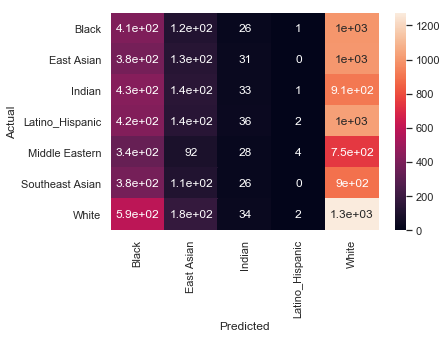

In [186]:
# Predict the output
test_generator_r.reset()
pred=model_3r.predict_generator(test_generator_r,
            steps=STEP_SIZE_TEST,
            verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator_r.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

data = {'y_Actual':    testdf['race'][:-10],
        'y_Predicted': predictions
        }

df_cm = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

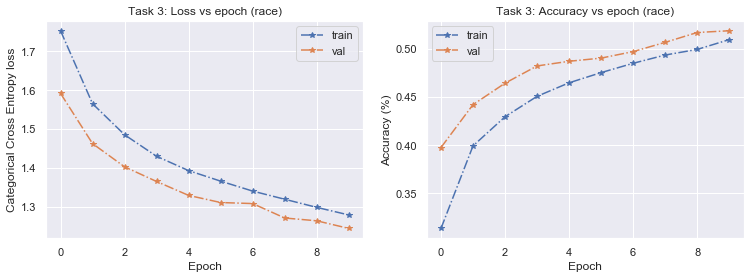

In [187]:
plt.figure(figsize=[12.5,4])
plt.subplot(1,2,1)
plt.plot(history_3r.history['loss'],'-.*', label='train')
plt.plot(history_3r.history['val_loss'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross Entropy loss")
plt.title("Task 3: Loss vs epoch (race)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_3r.history['accuracy'],'-.*', label='train')
plt.plot(history_3r.history['val_accuracy'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Task 3: Accuracy vs epoch (race)")
plt.legend()

Gender

In [188]:
# Task 3: Your Own ConvNet (Gender)
model_3g = Sequential()
model_3g.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model_3g.add(Activation('relu'))
model_3g.add(Conv2D(32, (3, 3)))
model_3g.add(Activation('relu'))
model_3g.add(MaxPooling2D(pool_size=(2, 2)))
model_3g.add(Dropout(0.25))
model_3g.add(Conv2D(64, (3, 3), padding='same'))
model_3g.add(Activation('relu'))
model_3g.add(Conv2D(64, (3, 3)))
model_3g.add(Activation('relu'))
model_3g.add(MaxPooling2D(pool_size=(2, 2)))
model_3g.add(Dropout(0.25))
model_3g.add(Flatten())
model_3g.add(Dense(512))
model_3g.add(Activation('relu'))
model_3g.add(Dropout(0.5))
model_3g.add(Dense(2, activation='softmax'))
model_3g.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [138]:
STEP_SIZE_TRAIN=train_generator_g.n//train_generator_g.batch_size
STEP_SIZE_VALID=valid_generator_g.n//valid_generator_g.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

start_time = time.time()
history_3g = model_3g.fit_generator(generator=train_generator_g,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_g,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time)

Found 86744 validated image filenames belonging to 2 classes.
Found 10954 validated image filenames belonging to 2 classes.
Epoch 1/10
2710/2710 [==============================] - 191s 70ms/step - loss: 0.5971 - accuracy: 0.6666 - val_loss: 0.5060 - val_accuracy: 0.7505
Epoch 2/10
2710/2710 [==============================] - 191s 70ms/step - loss: 0.5032 - accuracy: 0.7462 - val_loss: 0.4556 - val_accuracy: 0.7807
Epoch 3/10
2710/2710 [==============================] - 190s 70ms/step - loss: 0.4657 - accuracy: 0.7708 - val_loss: 0.4288 - val_accuracy: 0.7918
Epoch 4/10
2710/2710 [==============================] - 191s 71ms/step - loss: 0.4412 - accuracy: 0.7837 - val_loss: 0.4101 - val_accuracy: 0.8044
Epoch 5/10
2710/2710 [==============================] - 190s 70ms/step - loss: 0.4224 - accuracy: 0.7967 - val_loss: 0.3970 - val_accuracy: 0.8101
Epoch 6/10
2710/2710 [==============================] - 191s 70ms/step - loss: 0.4061 - accuracy: 0.8057 - val_loss: 0.3975 - val_accuracy: 0

342/342 [==============================] - 4s 13ms/step
Predicted  Black  East Asian
Actual                      
Female      1294        3865
Male        1473        4312


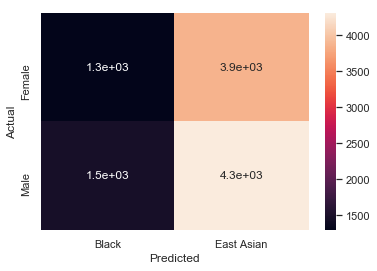

In [190]:
# Predict the output
test_generator_r.reset()
pred=model_3g.predict_generator(test_generator_r,
            steps=STEP_SIZE_TEST,
            verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator_r.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

data = {'y_Actual':    testdf['gender'][:-10],
        'y_Predicted': predictions
        }

df_cm = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

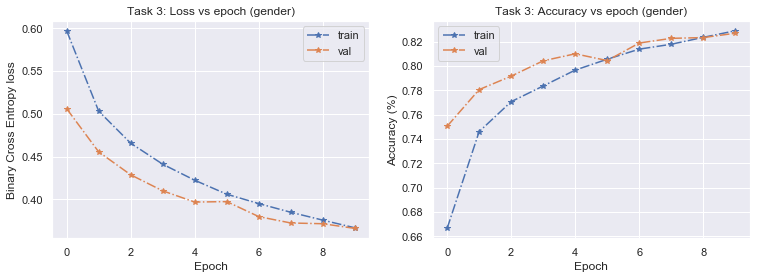

In [189]:
plt.figure(figsize=[12.5,4])
plt.subplot(1,2,1)
plt.plot(history_3g.history['loss'],'-.*', label='train')
plt.plot(history_3g.history['val_loss'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy loss")
plt.title("Task 3: Loss vs epoch (gender)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_3g.history['accuracy'],'-.*', label='train')
plt.plot(history_3g.history['val_accuracy'],'-.*', label='val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Task 3: Accuracy vs epoch (gender)")
plt.legend()